# Data Wrangling

This notebook provides an overview steps taken to create a data file containing information on Brexit voting, Age structure and Qualifications for England by combining 2011 census data with 2016 brexit data. It highlights challenges with UK data geography boundary changes that happened between 2011 and 2016. It also provides an example of *Data Wrangling*.

[Data wrangling](https://en.wikipedia.org/wiki/Data_wrangling) is a form of data manipulation and might be defined as:

> the process of transforming and mapping data from one "raw" data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes such as analytics. The goal of data wrangling is to assure quality and useful data. *Data analysts typically spend the majority of their time in the process of data wrangling compared to the actual analysis of the data.*

Note the point emphasised above - a lot of time and effort often needs to be invested to get data in the format you need for analysis. This is especially the case when trying to bring together data from different sources, as we'll see here.

## Setup

Import required packages

In [1]:
# Graphics
import matplotlib.pyplot as plt

# Wrangling
import geopandas as gpd
import pandas as pd

# Brexit Data 2016

The brexit data we use here were originally [provided](https://geographicdata.science/book/data/brexit/brexit_cleaning.html) by Rey *et al.* (2020) as two distinct datasets:

- Electoral Comission data on vote percentages at the local authority level. [CSV]
- ONS Local Authority Districts (December 2016) Generalised Clipped Boundaries in the UK WGS84 [geojson]. 

In [2]:
brexit_data_path = '../../data/brexit/brexit_vote.csv'
brexit = pd.read_csv(brexit_data_path, index_col='Area_Code')
brexit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, E06000031 to E08000036
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       382 non-null    int64  
 1   Region_Code              382 non-null    object 
 2   Region                   382 non-null    object 
 3   Area                     382 non-null    object 
 4   Electorate               382 non-null    int64  
 5   ExpectedBallots          382 non-null    int64  
 6   VerifiedBallotPapers     382 non-null    int64  
 7   Pct_Turnout              382 non-null    float64
 8   Votes_Cast               382 non-null    int64  
 9   Valid_Votes              382 non-null    int64  
 10  Remain                   382 non-null    int64  
 11  Leave                    382 non-null    int64  
 12  Rejected_Ballots         382 non-null    int64  
 13  No_official_mark         382 non-null    int64  
 14  Voting_for_both_a

In [3]:
lads = gpd.read_file("../../data/brexit/local_authority_districts.geojson").set_index('lad16cd')
lads.head()

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,None,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,None,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,0.028479,1.424195,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,0.009740,0.782168,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


In [4]:
gdf = gpd.GeoDataFrame(lads.join(brexit[['Pct_Leave']]), crs=lads.crs)
gdf = gdf[['objectid', 'lad16nm', 'Pct_Leave', 'geometry']].dropna()
gdf.head()

,objectid,lad16nm,Pct_Leave,geometry
lad16cd,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


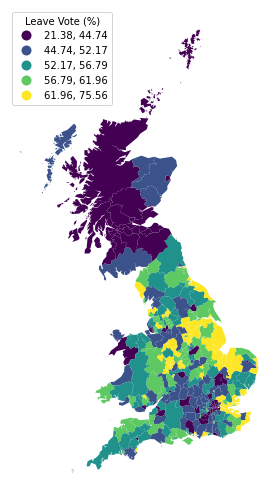

In [5]:
fig, ax = plt.subplots(1, figsize=(9, 9))
gdf.plot(column='Pct_Leave', cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":"Leave Vote (%)","loc": 2},
        ax=ax
       )
ax.set_axis_off()

# Census Data 2011

## Age Structure

Data table KS102EW was downloaded from the [ONS website](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/2011censuskeystatisticsforlocalauthoritiesinenglandandwales) 

This was in Excel format (*r21ewrttableks102ewladv1_tcm77-290566.xls*) with several sheets. Data on sheet KS102EW_Percentages for unitary authorities were extracted:

- header rows were removed
- all empty rows were removed
- all rows for non-UA regions were removed
- all rows for Wales UAs (Area codes starting W) were removed
- columns were renamed

The data were then saved in Excel (single sheet) and csv format:

- *england_agestructure_2011.xlsx*
- *england_agestructure_2011.csv*

We can then read the csv into a pandas DataFrame:

In [6]:
age_data_path = '../../data/census/england_agestructure_2011.csv'
age = pd.read_csv(age_data_path, index_col='Area_Code')
age.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326 entries, E06000001 to E09000033
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Area           326 non-null    object 
 1   Count_Persons  326 non-null    object 
 2   Pct_0-4        326 non-null    float64
 3   Pct_5-7        326 non-null    float64
 4   Pct_8-9        326 non-null    float64
 5   Pct_10-14      326 non-null    float64
 6   Pct_15         326 non-null    float64
 7   Pct_16-17      326 non-null    float64
 8   Pct_18-19      326 non-null    float64
 9   Pct_20-24      326 non-null    float64
 10  Pct_25-29      326 non-null    float64
 11  Pct_30-44      326 non-null    float64
 12  Pct_45-59      326 non-null    float64
 13  Pct_60-64      326 non-null    float64
 14  Pct_65-74      326 non-null    float64
 15  Pct_75-84      326 non-null    float64
 16  Pct_85-89      326 non-null    float64
 17  Pct_90p        326 non-null    float64
 18  M

## Qualifications

Data table KS501EW was downloaded from the [ONS website](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/2011censuskeystatisticsforlocalauthoritiesinenglandandwales) 

This was in Excel format (*r21ewrttableks501ewladv1_tcm77-290734.xls*) with several sheets. Data on sheet KS501EW_Percentages for unitary authorities were extracted:

- header rows were removed
- all empty rows were removed
- all rows for non-UA regions were removed
- all rows for Wales UAs (Area codes starting W) were removed
- columns were renamed

The data were then saved in Excel (single sheet) and csv format:

- *england_qualifications_2011.xlsx*
- *england_qualifications_2011.csv*

We can then read the csv into a pandas DataFrame:

In [7]:
quals_data_path = '../../data/census/england_qualifications_2011.csv'
quals = pd.read_csv(quals_data_path, index_col='Area_Code')
quals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326 entries, E06000001 to E09000033
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area            326 non-null    object 
 1   Count_Persons   326 non-null    object 
 2   Pct_None        326 non-null    float64
 3   Pct_Level1      326 non-null    float64
 4   Pct_Level2      326 non-null    float64
 5   Pct_Apprentice  326 non-null    float64
 6   Pct_Level3      326 non-null    float64
 7   Pct_Level4      326 non-null    float64
dtypes: float64(6), object(2)
memory usage: 22.9+ KB


# Merging Data

## Brexit and Census

If we look at the bottom rows of our Brexit data frame, we can see that the Wales UAs still remain (Scotland UAs are in there too). 

In [8]:
brexit.sort_index().tail()

,id,Region_Code,Region,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,
W06000020,144,W92000004,Wales,Torfaen,68957,48177,48172,69.86,48172,48144,19363,28781,28,0,11,2,15,40.22,59.78,0.06
W06000021,145,W92000004,Wales,Monmouthshire,71607,55670,55670,77.74,55670,55630,28061,27569,40,19,0,0,21,50.44,49.56,0.07
W06000022,146,W92000004,Wales,Newport,104977,73708,73708,70.21,73708,73649,32413,41236,59,3,29,2,25,44.01,55.99,0.08
W06000023,132,W92000004,Wales,Powys,103270,79519,79517,77.00,79515,79469,36762,42707,46,0,17,7,22,46.26,53.74,0.06
W06000024,141,W92000004,Wales,Merthyr Tydfil,42855,28881,28881,67.39,28881,28865,12574,16291,16,0,7,1,8,43.56,56.44,0.06


This shouldn't be a problem; if we do our merge correctly these will be dropped leaving only the England data.

We want to retain only rows found in both tables so an `inner` join will be appropriate (this will drop the Wales and Scotland UAs as they are not found in the Age DF because we deleted them manually above). We should be able to join on `Area_Code` as this is common in both DataFrames. 

In [9]:
england = age.merge(brexit, how='inner', on='Area_Code')
england.sort_index().tail()

,Area_x,Count_Persons,Pct_0-4,Pct_5-7,Pct_8-9,Pct_10-14,Pct_15,Pct_16-17,Pct_18-19,Pct_20-24,...,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,,
E09000029,Sutton,"190,146",6.7,3.6,2.2,6.1,1.3,2.7,2.1,5.6,...,49319,57241,73,0,25,7,41,46.28,53.72,0.07
E09000030,Tower Hamlets,"254,096",7.4,3.8,2.3,5.2,1.0,1.9,2.8,12.1,...,73011,35224,185,0,105,6,74,67.46,32.54,0.17
E09000031,Waltham Forest,"258,249",8.1,4.0,2.4,5.7,1.2,2.4,2.3,8.0,...,64156,44395,138,4,44,9,81,59.10,40.90,0.13
E09000032,Wandsworth,"306,995",7.1,3.0,1.7,4.1,0.7,1.5,1.8,7.7,...,118463,39421,134,0,55,0,79,75.03,24.97,0.08
E09000033,Westminster,"219,396",5.8,2.8,1.7,3.9,0.7,1.5,2.3,8.0,...,53928,24268,129,0,47,1,81,68.97,31.03,0.16


Looking at the `info`, the result seems to be right. We have (only) 320 rows with columns from both DataFrames:

In [10]:
england.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, E06000001 to E09000033
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area_x                   320 non-null    object 
 1   Count_Persons            320 non-null    object 
 2   Pct_0-4                  320 non-null    float64
 3   Pct_5-7                  320 non-null    float64
 4   Pct_8-9                  320 non-null    float64
 5   Pct_10-14                320 non-null    float64
 6   Pct_15                   320 non-null    float64
 7   Pct_16-17                320 non-null    float64
 8   Pct_18-19                320 non-null    float64
 9   Pct_20-24                320 non-null    float64
 10  Pct_25-29                320 non-null    float64
 11  Pct_30-44                320 non-null    float64
 12  Pct_45-59                320 non-null    float64
 13  Pct_60-64                320 non-null    float64
 14  Pct_65-74        

But note that we have columns `Area_x` and `Area_y` - this is because we had an `Area` column in both original tables. We'll rename them just so we know where they originally came from in future:

In [11]:
england = england.rename(columns={"Area_x": "Area_age", 
                                  "Area_y": "Area_brexit"})

In [12]:
england.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, E06000001 to E09000033
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area_age                 320 non-null    object 
 1   Count_Persons            320 non-null    object 
 2   Pct_0-4                  320 non-null    float64
 3   Pct_5-7                  320 non-null    float64
 4   Pct_8-9                  320 non-null    float64
 5   Pct_10-14                320 non-null    float64
 6   Pct_15                   320 non-null    float64
 7   Pct_16-17                320 non-null    float64
 8   Pct_18-19                320 non-null    float64
 9   Pct_20-24                320 non-null    float64
 10  Pct_25-29                320 non-null    float64
 11  Pct_30-44                320 non-null    float64
 12  Pct_45-59                320 non-null    float64
 13  Pct_60-64                320 non-null    float64
 14  Pct_65-74        

Now we can merge the Qualifications DF to our England DF, again using `inner` on `Area_Code`:

In [13]:
england = england.merge(quals, how='inner', on='Area_Code')
england.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, E06000001 to E09000033
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area_age                 320 non-null    object 
 1   Count_Persons_x          320 non-null    object 
 2   Pct_0-4                  320 non-null    float64
 3   Pct_5-7                  320 non-null    float64
 4   Pct_8-9                  320 non-null    float64
 5   Pct_10-14                320 non-null    float64
 6   Pct_15                   320 non-null    float64
 7   Pct_16-17                320 non-null    float64
 8   Pct_18-19                320 non-null    float64
 9   Pct_20-24                320 non-null    float64
 10  Pct_25-29                320 non-null    float64
 11  Pct_30-44                320 non-null    float64
 12  Pct_45-59                320 non-null    float64
 13  Pct_60-64                320 non-null    float64
 14  Pct_65-74        

This time we have two `Count_Persons` columns. We'll rename them so we remember their origin:

In [14]:
england = england.rename(columns={"Count_Persons_x": "Count_Persons_age", 
                                  "Count_Persons_y": "Count_Persons_quals"})

In [15]:
england.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, E06000001 to E09000033
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area_age                 320 non-null    object 
 1   Count_Persons_age        320 non-null    object 
 2   Pct_0-4                  320 non-null    float64
 3   Pct_5-7                  320 non-null    float64
 4   Pct_8-9                  320 non-null    float64
 5   Pct_10-14                320 non-null    float64
 6   Pct_15                   320 non-null    float64
 7   Pct_16-17                320 non-null    float64
 8   Pct_18-19                320 non-null    float64
 9   Pct_20-24                320 non-null    float64
 10  Pct_25-29                320 non-null    float64
 11  Pct_30-44                320 non-null    float64
 12  Pct_45-59                320 non-null    float64
 13  Pct_60-64                320 non-null    float64
 14  Pct_65-74        

## Non-spatial and Spatial

Now we are ready to merge our DF to the spatial data (with `geometry` column) so we can check how the data look spatially. 

If we look at the indexes of our data we can see that they contain the Area Codes that are unique for each UA:

In [16]:
england.index

Index(['E06000001', 'E06000002', 'E06000003', 'E06000004', 'E06000005',
       'E06000006', 'E06000007', 'E06000008', 'E06000009', 'E06000010',
       ...
       'E09000024', 'E09000025', 'E09000026', 'E09000027', 'E09000028',
       'E09000029', 'E09000030', 'E09000031', 'E09000032', 'E09000033'],
      dtype='object', name='Area_Code', length=320)

In [17]:
lads.index

Index(['E06000001', 'E06000002', 'E06000003', 'E06000004', 'E06000010',
       'E06000011', 'E06000032', 'E06000005', 'E06000006', 'E06000033',
       ...
       'W06000024', 'W06000013', 'W06000014', 'W06000015', 'W06000016',
       'W06000018', 'W06000019', 'W06000021', 'W06000022', 'W06000023'],
      dtype='object', name='lad16cd', length=391)

So we should be able to use these to `merge`. This time, we use `left_index=True` and `right_index=True` as the keys for the merge are the indexes of the DFs, not in columns. 

In [18]:
Egdf = lads.merge(england, how='inner', 
                  left_index=True, right_index=True)

And now we can plot a map to check everything has gone well:

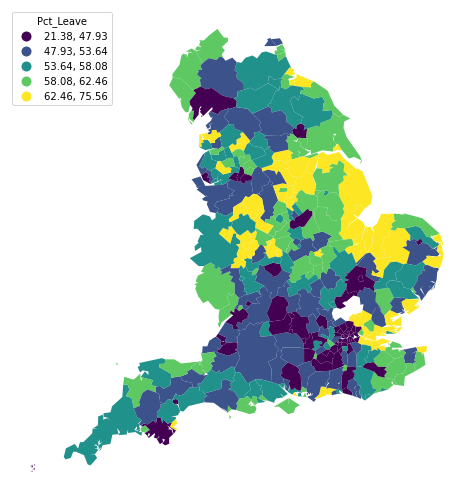

In [19]:
col='Pct_Leave' 
fig, ax = plt.subplots(1, figsize=(9, 9))
Egdf.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )
ax.set_axis_off()

Oh dear, we seem to have some areas missing - see just north of London there are some missing polygons! Why is this?

# Mismatches

## Identification
The problem is likely arising because of some issues when merging data tables. To investigate we need to compare the Area Codes in the data files we used. Because the age and qualifications data come from the ONS website it's unlikely to be a discrepancy between them (they will have been carefully error-checked). More likely is a discrepancy between the 2011 Census data and the 2016 Brexit data. 

To check, I extracted error codes from  

- brexit_vote.csv
- england_agestructure_2011.csv

and pasted the `Area_Code` and `Area` (name) columns into a new spreadsheet to compare (see file codechanges_2011-2016.xlsx):

- sorted on 2016 Area_Code
- deleted Wales codes from 2016
- compared line-by-line to look for mis-matches between 2011 and 2016 area

Sure enough I found the there were different codes for some areas:

| 2016 | Name | 2011 |
|------|------|------|
|E06000057 |Northumberland|E06000048|
|E07000242|East Hertfordshire|	E07000097|
|E07000240|	St Albans|	E07000100|
|E07000243|	Stevenage|	E07000101|
|E07000241|	Welwyn Hatfield|	E07000104|

[A page on the ONS website](https://www.ons.gov.uk/methodology/geography/ukgeographies/administrativegeography/ourchanginggeography) provides an overview of how changes in UK data geography are handled. Specifically,

> The ONS Coding and Naming Policy for UK Statistical Geographies explains that local authority codes will be changed if any boundary change occurs, however small  [[source pdf](http://www.ons.gov.uk/ons/guide-method/geography/geographic-policy/coding-and-naming-policy-for-uk-statistical-geographies.zip)]

And we can see this in our DFs:

In [20]:
lads[lads['lad16nm']=='Stevenage']

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
lad16cd,,,,,,,,,,
E07000243,257,Stevenage,None,524622,224531,-0.18987,51.905392,0.003389,0.328754,"POLYGON ((-0.17254 51.92855, -0.23439 51.90525..."


In [21]:
brexit[brexit['Area']=='Stevenage']

,id,Region_Code,Region,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,
E07000243,257,E12000006,East,Stevenage,62156,45811,45811,73.7,45811,45785,18659,27126,26,0,12,2,12,40.75,59.25,0.06


In [22]:
england[england['Area_age']=='Stevenage']

,Area_age,Count_Persons_age,Pct_0-4,Pct_5-7,Pct_8-9,Pct_10-14,Pct_15,Pct_16-17,Pct_18-19,Pct_20-24,...,Pct_Leave,Pct_Rejected,Area,Count_Persons_quals,Pct_None,Pct_Level1,Pct_Level2,Pct_Apprentice,Pct_Level3,Pct_Level4
Area_Code,,,,,,,,,,,,,,,,,,,,,


In [23]:
age[age['Area']=='Stevenage']

,Area,Count_Persons,Pct_0-4,Pct_5-7,Pct_8-9,Pct_10-14,Pct_15,Pct_16-17,Pct_18-19,Pct_20-24,Pct_25-29,Pct_30-44,Pct_45-59,Pct_60-64,Pct_65-74,Pct_75-84,Pct_85-89,Pct_90p,Mean_age,Median_age
Area_Code,,,,,,,,,,,,,,,,,,,,
E07000101,Stevenage,"83,957",7.0,3.6,2.3,6.1,1.3,2.7,2.6,6.5,7.3,21.2,20.3,4.9,7.1,5.2,1.2,0.6,37.8,37


So Stevenage (and the other areas) failed to make it into the `england` DF at this point:

```england = age.merge(brexit, how='inner', on='Area_Code')```

Because `inner` returns only indexes found in **both** tables, we dropped Wales and Scotland but we *also* lost these English areas that had their codes changed. 

For example, note how age has 326 rows, but england has 320! (I missed that when initially doing my data wrnagling)

## Fixes

We can use the spreadsheet we created to visually look for mismatches to fix them. First, load the data in:

In [24]:
#csv from my spreadsheet analysis 
codes_data_path = '../../data/census/codechanges_2011-2016.csv'
codes = pd.read_csv(codes_data_path)

Now [re-set the `index`](https://stackoverflow.com/a/49951825) of `brexit` using the 2011 codes:

In [25]:
#from https://stackoverflow.com/a/49951825
c2016 = codes['Area_Code_2016']
c2011 = codes['Area_Code_2011']
brexit = brexit.rename(index=dict(zip(c2016,c2011)))

Check Stevenage code has been fixed:

In [26]:
brexit[brexit['Area']=='Stevenage']

,id,Region_Code,Region,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,
E07000101,257,E12000006,East,Stevenage,62156,45811,45811,73.7,45811,45785,18659,27126,26,0,12,2,12,40.75,59.25,0.06


And now we can re-do the merge above to create `england` afresh:

In [27]:
england = age.merge(brexit, how='inner', on='Area_Code')
england.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326 entries, E06000001 to E09000033
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area_x                   326 non-null    object 
 1   Count_Persons            326 non-null    object 
 2   Pct_0-4                  326 non-null    float64
 3   Pct_5-7                  326 non-null    float64
 4   Pct_8-9                  326 non-null    float64
 5   Pct_10-14                326 non-null    float64
 6   Pct_15                   326 non-null    float64
 7   Pct_16-17                326 non-null    float64
 8   Pct_18-19                326 non-null    float64
 9   Pct_20-24                326 non-null    float64
 10  Pct_25-29                326 non-null    float64
 11  Pct_30-44                326 non-null    float64
 12  Pct_45-59                326 non-null    float64
 13  Pct_60-64                326 non-null    float64
 14  Pct_65-74        

Note we have 326 rows above, not 320 as we did before!

Rename the `Area` columns again and check Stevenage:

In [28]:
england = england.rename(columns={"Area_x": "Area_age", 
                                  "Area_y": "Area_brexit"})
england[england['Area_age']=='Stevenage']

,Area_age,Count_Persons,Pct_0-4,Pct_5-7,Pct_8-9,Pct_10-14,Pct_15,Pct_16-17,Pct_18-19,Pct_20-24,...,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,,
E07000101,Stevenage,"83,957",7.0,3.6,2.3,6.1,1.3,2.7,2.6,6.5,...,18659,27126,26,0,12,2,12,40.75,59.25,0.06


Merge qualifications again:

In [29]:
england = england.merge(quals, how='inner', on='Area_Code')
england = england.rename(columns={"Count_Persons_x": "Count_Persons_age", 
                                  "Count_Persons_y": "Count_Persons_quals"})
england.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326 entries, E06000001 to E09000033
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area_age                 326 non-null    object 
 1   Count_Persons_age        326 non-null    object 
 2   Pct_0-4                  326 non-null    float64
 3   Pct_5-7                  326 non-null    float64
 4   Pct_8-9                  326 non-null    float64
 5   Pct_10-14                326 non-null    float64
 6   Pct_15                   326 non-null    float64
 7   Pct_16-17                326 non-null    float64
 8   Pct_18-19                326 non-null    float64
 9   Pct_20-24                326 non-null    float64
 10  Pct_25-29                326 non-null    float64
 11  Pct_30-44                326 non-null    float64
 12  Pct_45-59                326 non-null    float64
 13  Pct_60-64                326 non-null    float64
 14  Pct_65-74        

Now we have our non-spatial data tables combined, all using 2011 Area Codes. But our spatial data are from 2016! So before we can comabine spatial and non-spatial we have to convert the 2011 Area Codes back to 2016:  

In [30]:
#from https://stackoverflow.com/a/49951825
c2016 = codes['Area_Code_2016']
c2011 = codes['Area_Code_2011']
england = england.rename(index=dict(zip(c2011,c2016)))

Now we can merge spatial and non-spatial:

In [31]:
Egdf = lads.merge(england, how='inner', 
                  left_index=True, right_index=True)

And check:

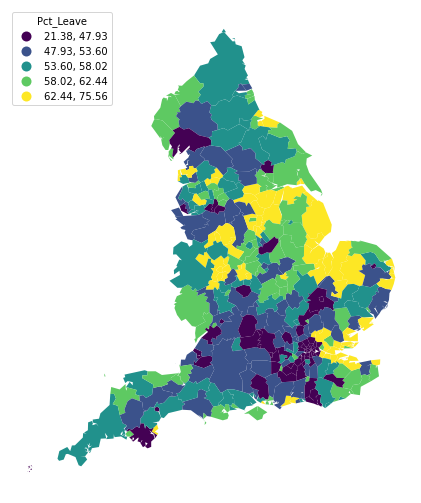

In [32]:
col='Pct_Leave' 
fig, ax = plt.subplots(1, figsize=(9, 9))
Egdf.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )
ax.set_axis_off()

And try mapping with a different variable, one we've added:

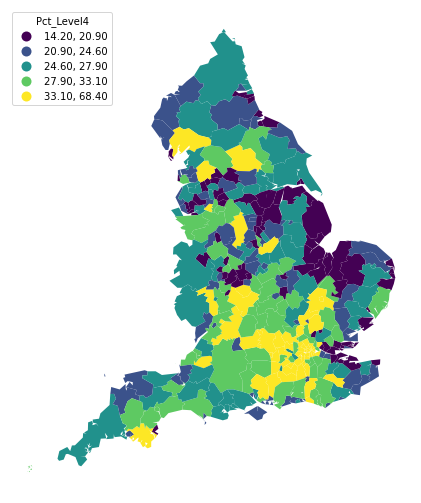

In [33]:
col='Pct_Level4' 
fig, ax = plt.subplots(1, figsize=(9, 9))
Egdf.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )
ax.set_axis_off()

This is now looking good. Through all the checks we've done, visual and otherwise, we should now be confident we've got a consistent data set. 

So let's read that out for future use so we don't have to do this wrangling again:

In [34]:
england.to_csv("../../data/brexit/england_age_qual_vote.csv")

Quite the effort, but often necessary! 

## Exercise

If you want to practice yourself, try adding the data from Table KS204EW (*r21ewrttableks204ewladv2_tcm77-290617.xls*) on Country of Birth (or any other table on ONS website for 2011 Census) to the `Egdf` GeoDataFrame. 